In [3]:
import os
import random

import numpy as np

from PIL import Image
from PIL import ImageFilter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

import torchvision as tv
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet34_Weights
import torchvision.transforms.functional as F
from torchvision.transforms.transforms import RandomAffine, Resize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
all_data_tensor = torch.load('./data_tensor.pth')
all_labels_tensor = torch.load('./labels_tensor.pth');

In [3]:
dataset = []
for i in range(len(all_labels_tensor)):
    dataset.append((all_data_tensor[i], all_labels_tensor[i]))

In [4]:
torch.manual_seed(42)
total_size = len(dataset)
train_size = int(total_size * 0.7)  # 70% for training
val_size = int(total_size * 0.2)    # 20% for validation

test_size = total_size - train_size - val_size  # Remaining 10% for testing

In [5]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [8]:
resnet34 = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

In [9]:
out_features = 64

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # remove fully connected layer at the end
        self.resnet = nn.Sequential(*list(resnet18.children())[:-1])

        # freeze parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.fc1 = nn.Linear(resnet18.fc.in_features, out_features)
        self.fc2 = nn.Linear(out_features, 30)
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        
        # Forward pass through your fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [10]:
# get the accuracy of the model prediction and the actual value
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.backends.mps.is_built():
            imgs = imgs.to("mps")
            labels = labels.to("mps")
        # get the output using alex net
        output = model(imgs)

        # select index with maximum prediction
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [11]:
# train the model using alex net
def train(model, data, batch_size, num_epochs, learning_rate, momentum):
    # use cross entropy loss function and SGD with momentum
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []


    n = 0
    for epoch in range(num_epochs):
        mini_b = 0
        mini_batch_correct = 0
        mini_batch_total = 0
        print("epoch: {}".format(epoch))

        for imgs, labels in iter(train_loader):
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")
            # calculate loss
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # find the loss and accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            train_acc.append(mini_batch_correct / mini_batch_total)
            iters.append(n)
            losses.append(float(loss) / batch_size)
            val_acc.append(get_accuracy(model, train=False))
            n += 1
            mini_b += 1
        
        # print the accuracy
        print("Training Accuracy = {}".format(train_acc[-1]))
        print("Validation Accuracy = {}".format(val_acc[-1]))

    # plot the loss curve
    plt.title("Loss Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # plot the training and validation curve
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    # print the final accuracies
    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    


epoch: 0
Training Accuracy = 0.06666666666666667
Validation Accuracy = 0.06698564593301436
epoch: 1
Training Accuracy = 0.1
Validation Accuracy = 0.0861244019138756
epoch: 2
Training Accuracy = 0.13333333333333333
Validation Accuracy = 0.215311004784689
epoch: 3
Training Accuracy = 0.36666666666666664
Validation Accuracy = 0.1674641148325359
epoch: 4
Training Accuracy = 0.4
Validation Accuracy = 0.2631578947368421
epoch: 5
Training Accuracy = 0.36666666666666664
Validation Accuracy = 0.2822966507177033
epoch: 6
Training Accuracy = 0.43333333333333335
Validation Accuracy = 0.3157894736842105
epoch: 7
Training Accuracy = 0.5
Validation Accuracy = 0.3492822966507177
epoch: 8
Training Accuracy = 0.5
Validation Accuracy = 0.41626794258373206
epoch: 9
Training Accuracy = 0.5333333333333333
Validation Accuracy = 0.4688995215311005
epoch: 10
Training Accuracy = 0.7666666666666667
Validation Accuracy = 0.45933014354066987
epoch: 11
Training Accuracy = 0.6
Validation Accuracy = 0.440191387559808

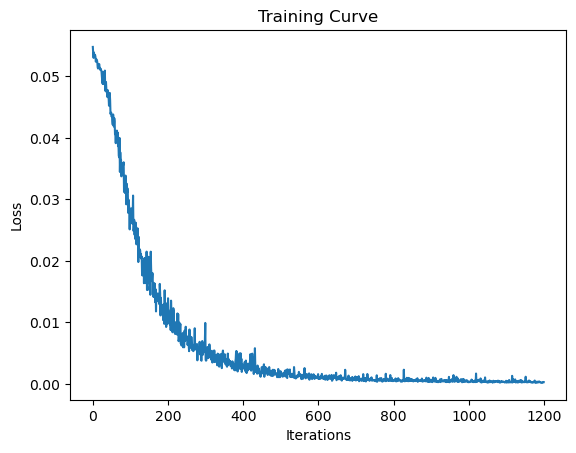

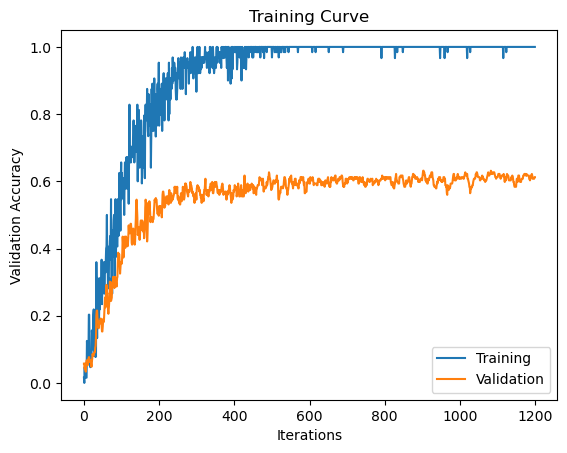

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6124401913875598


In [48]:
# use res net 
model = ANN()

# hyperparameters
num_epochs = 100
learning_rate = 0.01
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model, [], batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum)

epoch: 0
Training Accuracy = 0.03333333333333333
Validation Accuracy = 0.0430622009569378
epoch: 1
Training Accuracy = 0.03333333333333333
Validation Accuracy = 0.0430622009569378
epoch: 2
Training Accuracy = 0.13333333333333333
Validation Accuracy = 0.11004784688995216
epoch: 3
Training Accuracy = 0.2
Validation Accuracy = 0.16267942583732056
epoch: 4
Training Accuracy = 0.23333333333333334
Validation Accuracy = 0.19617224880382775
epoch: 5
Training Accuracy = 0.3333333333333333
Validation Accuracy = 0.27751196172248804
epoch: 6
Training Accuracy = 0.26666666666666666
Validation Accuracy = 0.23444976076555024
epoch: 7
Training Accuracy = 0.3333333333333333
Validation Accuracy = 0.3014354066985646
epoch: 8
Training Accuracy = 0.36666666666666664
Validation Accuracy = 0.3684210526315789
epoch: 9
Training Accuracy = 0.5
Validation Accuracy = 0.3349282296650718
epoch: 10
Training Accuracy = 0.43333333333333335
Validation Accuracy = 0.3827751196172249
epoch: 11
Training Accuracy = 0.5
Vali

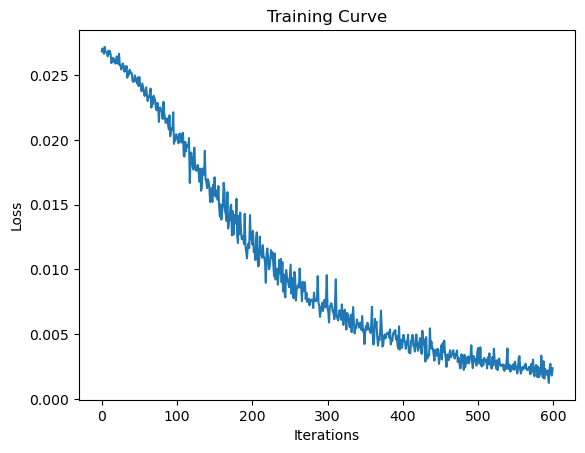

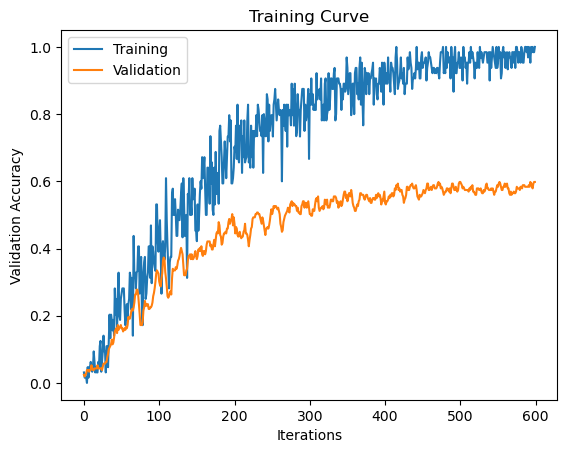

Final Training Accuracy: 0.9795640326975477
Final Validation Accuracy: 0.5980861244019139


In [49]:
# use res net 
model = ANN()

# hyperparameters
num_epochs = 50
learning_rate = 0.005
momentum = 0.9
batch_size = 128

if torch.backends.mps.is_built():
    model.to("mps")

train(model, [], batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum)

epoch: 0
Training Accuracy = 0.06666666666666667
Validation Accuracy = 0.03827751196172249
epoch: 1
Training Accuracy = 0.13333333333333333
Validation Accuracy = 0.09090909090909091
epoch: 2
Training Accuracy = 0.3
Validation Accuracy = 0.1339712918660287
epoch: 3
Training Accuracy = 0.26666666666666666
Validation Accuracy = 0.20574162679425836
epoch: 4
Training Accuracy = 0.23333333333333334
Validation Accuracy = 0.2583732057416268
epoch: 5
Training Accuracy = 0.26666666666666666
Validation Accuracy = 0.3062200956937799
epoch: 6
Training Accuracy = 0.5
Validation Accuracy = 0.36363636363636365
epoch: 7
Training Accuracy = 0.6
Validation Accuracy = 0.41148325358851673
epoch: 8
Training Accuracy = 0.5333333333333333
Validation Accuracy = 0.3923444976076555
epoch: 9
Training Accuracy = 0.4666666666666667
Validation Accuracy = 0.4784688995215311
epoch: 10
Training Accuracy = 0.5666666666666667
Validation Accuracy = 0.45933014354066987
epoch: 11
Training Accuracy = 0.6666666666666666
Valid

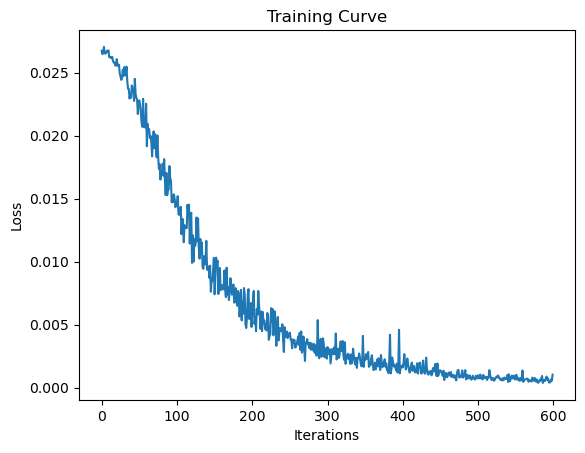

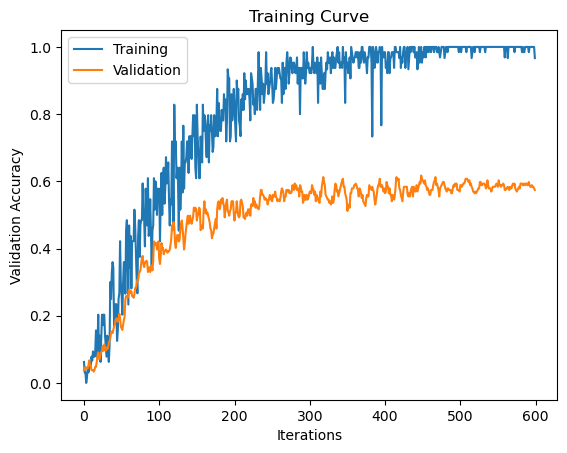

Final Training Accuracy: 0.997275204359673
Final Validation Accuracy: 0.5741626794258373


In [53]:
# use res net 
model = ANN()

# hyperparameters
num_epochs = 50
learning_rate = 0.01
momentum = 0.9
batch_size = 128

if torch.backends.mps.is_built():
    model.to("mps")

train(model, [], batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum)